<a href="https://colab.research.google.com/github/juhee3199/Machine-learning_advanced-study/blob/master/classification/Ensemble-%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EC%82%AC%EA%B8%B0%EA%B2%80%EC%B6%9C_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 캐글 신용카드 사기 검출 데이터
: https://www.kaggle.com/mlg-ulb/creditcardfraud
- 불균형한 분포를 가진 데이터
- --> 오버 샘플링 수행 (SMOTE)

In [1]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 1.5MB 8.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=fdb5e00ea732f87b4da718c98b5b8db15fbf04042e504c65cfe2385511d95ff1
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [2]:
# kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle -v

Kaggle API 1.5.6


In [5]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

!unzip creditcardfraud.zip

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [8]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

-  왜곡된 데이터(Amount) 분포도 변환하기

  - LogisticRegression은 선형모델
  - 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다.

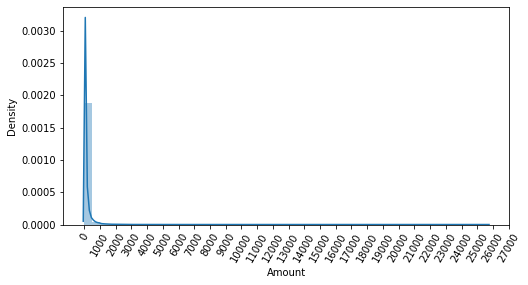

In [28]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

# Amount 피쳐가 왜곡된 분포를 나타냄
# --> 표준 정규 분포 형태로 변환하기

In [47]:
from sklearn.preprocessing import StandardScaler

# 전처리
def get_preprocessed_df(df=None):
  df_copy = df.copy()

  # Amount를 표준 정규 분포 형태로 변환하기
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  #기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1, inplace=True)

  return df_copy

In [48]:
from sklearn.model_selection import train_test_split

# 사전 데이터 가공 후, train, test 데이터셋 반환
def get_train_test_df(df=None):
  # 전처리
  df_copy = get_preprocessed_df(df)
  
  x_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  # train, test 분할
  x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size =0.3, random_state=0, stratify=y_target)

  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_train_test_df(card_df)

In [49]:
print('train 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('test 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

train 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
test 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

# 평가지표
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
# 사이킷런의 estimator 객체와 train,test 데이터셋을 입력받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train = None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [51]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)

오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,          F1: 0.7143, AUC:0.9702


In [52]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,  x_train, x_test, y_train, y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,          F1: 0.8421, AUC:0.9773


- 로그변환 수행

In [53]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()

  # Amount를 numpy의 log1p()를 이용해서 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  #기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1, inplace=True)

  return df_copy

In [54]:
x_train, x_test, y_train, y_test = get_train_test_df(card_df)


lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)

오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,          F1: 0.7149, AUC:0.9727


In [55]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,  x_train, x_test, y_train, y_test)

오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,          F1: 0.8496, AUC:0.9786


- 이상치 확인 및 제거

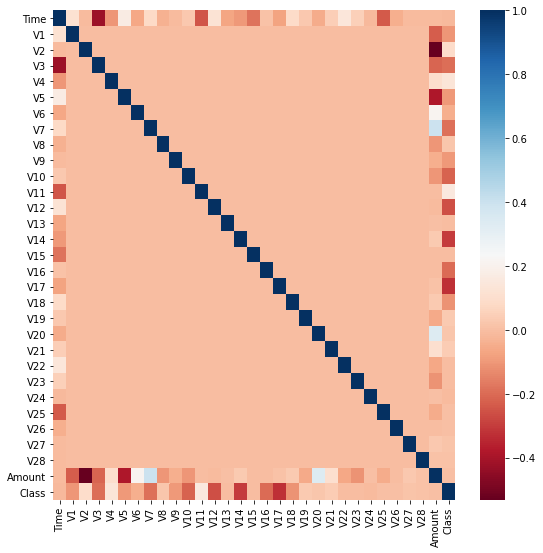

In [38]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

# class 와 음의 상관관계가 가장 높은 feature: V14, V17

In [56]:
# V14의 이상치 제거

import numpy as np

def get_outlier(df=None, column = None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75) 

  iqr = quantile_75 - quantile_25
  iqr_wieght = iqr*weight
  lowest_val = quantile_25 - iqr_wieght
  highest_val = quantile_75 - iqr_wieght
  # 이상치 설정
  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index


outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
outlier_index

Int64Index([   541,    623,   4920,   6108,   6329,   6331,   6334,   6336,
              6338,   6427,
            ...
            274382, 274475, 275992, 276071, 276864, 279863, 280143, 280149,
            281144, 281674],
           dtype='int64', length=433)

In [57]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()

  # Amount를 numpy의 log1p()를 이용해서 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  #기존 Time, Amount 피처 삭제
  df_copy.drop(['Time','Amount'],axis=1, inplace=True)
  #이상치 제거
  outlier_index = get_outlier(df = df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

In [58]:
x_train, x_test, y_train, y_test = get_train_test_df(card_df)


lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)

오차 행렬
[[85293     2]
 [    1    17]]
정확도: 1.0000, 정밀도: 0.8947, 재현율: 0.9444,          F1: 0.9189, AUC:1.0000


In [59]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,  x_train, x_test, y_train, y_test)

오차 행렬
[[85295     0]
 [    1    17]]
정확도: 1.0000, 정밀도: 1.0000, 재현율: 0.9444,          F1: 0.9714, AUC:1.0000


- SMOTE 오버 샘플링 적용 후

  - SMOTE를 적용하면 일반적으로 재현율은 높아지고, 정밀도는 낮아진다.
  - 좋은 SMOTE 패키지 일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있또록 효과적으로 데이터를 증식한다.

In [64]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
x_train_over, y_train_over = smote.fit_sample(x_train, y_train)
print('SMOTE 적용 전', x_train.shape, y_train.shape)
print('SMOTE 적용 후', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 \n', pd.Series(y_train_over).value_counts())

# 적용 후, 2배에 가깝게 증식됌. 0과 1의 분포가 동일해짐

SMOTE 적용 전 (199061, 29) (199061,)
SMOTE 적용 후 (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 
 1    199020
0    199020
dtype: int64


In [66]:
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, x_train_over, x_test, y_train_over, y_test)

오차 행렬
[[85292     3]
 [    1    17]]
정확도: 1.0000, 정밀도: 0.8500, 재현율: 0.9444,          F1: 0.8947, AUC:1.0000


In [67]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,  x_train_over, x_test, y_train_over, y_test)

오차 행렬
[[85293     2]
 [    0    18]]
정확도: 1.0000, 정밀도: 0.9000, 재현율: 1.0000,          F1: 0.9474, AUC:1.0000
